# Load data

In [1]:
import pandas as pd
import time
from sklearn.metrics import classification_report
import numpy as np
import os
import requests
import json
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

datapath = os.path.join('..', 'data', 'Iris.csv')

df = pd.read_csv(datapath)
df = df.drop(columns=['Id'])
print(df.shape)
df.head()

(150, 5)


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Missing Data Exploration

<AxesSubplot:>

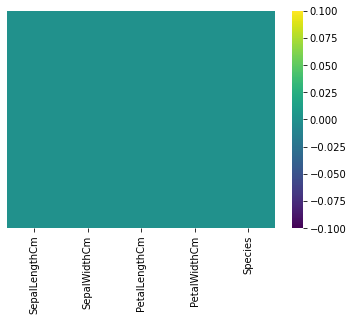

In [2]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis'
           #,vmax=1.0, vmin=-1.0   # these solve the boolean - problem
           )

# Train/Test Split

In [3]:
train_X, test_X, train_Y, test_Y = train_test_split(df[[col for col in df.columns if col!='Species']], 
                                                    df['Species'],
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=df['Species'])

# Standard Scaling

In [4]:
scaler = StandardScaler()
train_X_norm = scaler.fit_transform(train_X)
test_X_norm = scaler.transform(test_X)

# Model Train

In [15]:
paramGrid = {'nthread':[6],                           # when use hyperthread, xgboost may become slower
              'objective':['multi:softmax'],          # also joblib threading crushes the kernel
              'learning_rate': [0.10, 0.2, 0.3, 0.4],
              'max_depth': [4, 6, 8],
              'min_child_weight' : [1, 2, 4],
              'subsample': [0.8],
              'gamma' : [ 0.0, 0.1, 0.2 , 0.3, 0.4],   # a.k.a min_split_loss
              'lambda' : [1, 2, 4],                    # L2 reg
              'colsample_bytree' : [0.3, 0.5 , 0.7],
              'n_estimators': [10, 40, 80]}


k_fold = StratifiedKFold(n_splits=5)   

grid = GridSearchCV(XGBClassifier(), param_grid=paramGrid, 
                    scoring=('f1_macro'), n_jobs=-1, return_train_score=True, cv=k_fold) 

grid_result = grid.fit(train_X_norm, train_Y)
    
print("Best parameter set found:")
print(grid_result.best_params_)

model = grid_result.best_estimator_

# Make predictios from the best found model
pred_Y = model.predict(test_X_norm)
print(classification_report(test_Y, pred_Y)) 

print("Grid scores on development set:")
means = grid_result.cv_results_['mean_test_score']
print(means)
stds = grid_result.cv_results_['std_test_score']

[00:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameter set found:
{'colsample_bytree': 0.5, 'gamma': 0.0, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 10, 'nthread': 6, 'objective': 'multi:softmax', 'silent': 1, 'subsample': 0.8}
                 precision    recall  f1-score   support

    Iris-set

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


# Save best model

In [25]:
modelpath = os.path.join('..', 'model', 'xgb.model')
joblib.dump(model, modelpath) 

['..\\model\\xgb.model']

In [40]:
a = {1:'a', 2: 'b', 3: 'c'}
np.array(list(a.values()))

array(['a', 'b', 'c'], dtype='<U1')

In [42]:
model.predict(np.array([[5.1, 3.5, 1.4, 0.2]]))

array(['Iris-virginica'], dtype=object)

In [44]:
prediction = 'Iris-virginica'

In [45]:
{'prediction': prediction}

{'prediction': 'Iris-virginica'}

# Save Scaler for Inference

In [5]:
scalerpath = os.path.join('..', 'scaler', 'std_scaler.bin')
joblib.dump(scaler, scalerpath, compress=True)

['..\\scaler\\std_scaler.bin']

# Test that API is working

In [51]:
# Use this instead of requests.get to avoid delays!

session = requests.Session()
session.trust_env = False

data = {'SepalLengthCm':5.1, 'SepalWidthCm':3.5,
        'PetalLengthCm':1.4 , 'PetalWidthCm':0.2}

tries = 100
start = time.time()
for i in range(tries):
    response = session.get('http://localhost:8005', json=data)
    #print(response.json())
    continue
end = time.time()
elapsed = round(end-start,3)
reqsPerSec = round(float(tries/elapsed),3)
print("Elapsed time:", elapsed,"seconds,", reqsPerSec,"requests/sec")  

Elapsed time: 2.223 seconds, 44.984 requests/sec
